# Zero-shot Next Item Recommendation using Mistral-7B

## Setup

### Installing required models

In [ ]:
!pip install cohere
!pip install tiktoken
!pip install optimum
!pip install transformers[sentencepiece]
!pip install langchain
!pip install safetensors
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires openai, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 27.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
import json
import random
import transformers
import torch
import pickle

from transformers import AutoTokenizer, pipeline, logging
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

length_limit = 8
num_cand = 19
random_seed = 2023

random.seed(random_seed)
%matplotlib inline

## Loading data set

In [ ]:
!wget https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/ml_100k.json
!wget https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/movie_indexes.pk
!wget https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/user_matrix_sim.pk
!wget https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/pop_dict.pk
!wget https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/item_matrix_sim.pk

--2023-11-22 14:32:21--  https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/ml_100k.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 764666 (747K) [text/plain]
Saving to: ‘ml_100k.json’

ml_100k.json        100%[===================>] 746.74K  1.59MB/s    in 0.5s    

2023-11-22 14:32:23 (1.59 MB/s) - ‘ml_100k.json’ saved [764666/764666]

--2023-11-22 14:32:23--  https://raw.githubusercontent.com/marcosmapl/tcc-nir-llms/main/movie_indexes.pk
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32761 (32K) [application/oc

In [ ]:
def read_json(file):
    with open(file) as f:
        return json.load(f)

def write_json(data, file):
    with open(file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

data_ml_100k = read_json("ml_100k.json")

print(type(data_ml_100k))
print(len(data_ml_100k))

<class 'list'>
943


## Preparing data

### Movie name-index dictionary

In [ ]:
# movie_names = set()

# for _ in range(1000):
#     # start_time = time.time()
#     for elem in data_ml_100k:
#         seq_list = elem[0].split(' | ')
#         movie_names.update(seq_list)
#     # tempos_ex.append(time.time() - start_time)

# movie_idx = {movie:idx for idx,movie in enumerate(list(movie_names))}
# movie_idx

In [ ]:
# with open('movie_indexes.pk', 'wb') as arq:
#   pickle.dump(movie_idx, arq)

In [ ]:
with open('movie_indexes.pk', 'rb') as arq:
  movie_idx = pickle.load(arq)

movie_idx

{"'Til There Was You": 0,
 'Dazed and Confused': 1,
 'Shanghai Triad (Yao a yao yao dao waipo qiao)': 2,
 'High Noon': 3,
 'Beverly Hills Cop III': 4,
 'The English Patient': 5,
 'Glory': 6,
 'Money Talks': 7,
 'Toy Story': 8,
 'Two Deaths': 9,
 'The War': 10,
 'Boys Life': 11,
 'Promesse, La': 12,
 'Flirt': 13,
 'Heat': 14,
 'Liar Liar': 15,
 'An Unforgettable Summer': 16,
 'The Promise, The (Versprechen,': 17,
 'GoodFellas': 18,
 'Angels in the Outfield': 19,
 'The Secret Garden': 20,
 'Harriet the Spy': 21,
 'Basic Instinct': 22,
 'Grease 2': 23,
 '2001: A Space Odyssey': 24,
 'The Ruling Class': 25,
 'Mortal Kombat: Annihilation': 26,
 'Hercules': 27,
 'Houseguest': 28,
 'Rendezvous in Paris (Rendez-vous de Paris, Les)': 29,
 '187': 30,
 'Fearless': 31,
 'The Portrait of a Lady': 32,
 'The Apostle': 33,
 'The Turning': 34,
 'The Truth About Cats & Dogs': 35,
 'Disclosure': 36,
 'Field of Dreams': 37,
 'When Night Is Falling': 38,
 'Glengarry Glen Ross': 39,
 'Looking for Richard': 

### User similarity matrix

TODO: optimize cosine computing

In [ ]:
# user_matrix = [] # user matrix

# for elem in data_ml_100k:    # iterate over user watched movies
#     item_hot_list = np.zeros(len(movie_idx))  # create one hot user-movie vector
#     for movie_name in elem[0].split(' | '):  # iterate over each movie and update one hot vector
#         item_pos = movie_idx[movie_name]
#         item_hot_list[item_pos] = 1
#     user_matrix.append(item_hot_list)   # add user vector to user matrix

# user_matrix = np.array(user_matrix)
# user_matrix_sim = np.dot(user_matrix, user_matrix.transpose()) # compute similarity (dot product)
# user_matrix_sim

In [ ]:
# with open('user_matrix_sim.pk', 'wb') as arq:
#   pickle.dump(user_matrix_sim, arq)

In [ ]:
with open('user_matrix_sim.pk', 'rb') as arq:
  user_matrix_sim = pickle.load(arq)

user_matrix_sim

array([[45.,  1.,  2., ...,  4.,  4.,  4.],
       [ 1., 49.,  0., ...,  1., 11.,  6.],
       [ 2.,  0., 50., ...,  3.,  1.,  1.],
       ...,
       [ 4.,  1.,  3., ..., 50.,  5.,  0.],
       [ 4., 11.,  1., ...,  5., 50.,  8.],
       [ 4.,  6.,  1., ...,  0.,  8., 20.]])

### Movie popularity dict

In [ ]:
# pop_dict = {}

# for elem in data_ml_100k:   # iterate over dataset
#     # elem = data_ml_100k[i]
#     seq_list = elem[0].split(' | ')
#     for movie in seq_list:  # iterate over each movie
#         if movie not in pop_dict:
#               pop_dict[movie] = 0
#         pop_dict[movie] += 1 # increment movie popularity

# pop_dict

In [ ]:
# with open('pop_dict.pk', 'wb') as arq:
#   pickle.dump(pop_dict, arq)

In [ ]:
with open('pop_dict.pk', 'rb') as arq:
  pop_dict = pickle.load(arq)

pop_dict

{"My Best Friend's Wedding": 100,
 'The English Patient': 240,
 'Face/Off': 79,
 'Psycho': 81,
 'The Princess Bride': 107,
 'Kids': 16,
 'Kids in the Hall: Brain Candy': 29,
 'Scream': 225,
 'The Craft': 43,
 'The Rock': 154,
 'The Shining': 80,
 'Mission: Impossible': 143,
 'Reality Bites': 46,
 'Aliens': 93,
 'Indiana Jones and the Last Crusade': 115,
 "One Flew Over the Cuckoo's Nest": 84,
 'In the Name of the Father': 33,
 'Return of the Jedi': 191,
 'The Silence of the Lambs': 131,
 'The Usual Suspects': 85,
 'Dances with Wolves': 79,
 "Monty Python's Life of Brian": 44,
 'Monty Python and the Holy Grail': 101,
 'The Full Monty': 176,
 'Clockwork Orange, A': 77,
 'Apocalypse Now': 62,
 'Trainspotting': 89,
 'The Doors': 17,
 "Mr. Holland's Opus": 136,
 'Independence Day (ID4)': 196,
 'Liar Liar': 229,
 'Titanic': 209,
 "What's Eating Gilbert Grape": 27,
 'The Saint': 160,
 'Donnie Brasco': 62,
 'The Empire Strikes Back': 117,
 'Beautiful Girls': 42,
 'Mars Attacks!': 84,
 'Broken 

### Item similarity matrix

In [ ]:
# i_item_dict = {}
# # i_item_id_list = []
# i_item_user_dict = {}
# i_item_p = 0

# for i, elem in enumerate(data_ml_100k):
#     seq_list = elem[0].split(' | ') # user watched movie list
#     for movie in seq_list:
#         if movie not in i_item_user_dict:
#             # item_hot_list = [0. for ii in range(len(data_ml_100k))]
#             item_hot_list = np.zeros(len(data_ml_100k))
#             i_item_user_dict[movie] = item_hot_list
#             i_item_dict[movie] = i_item_p
#             # i_item_id_list.append(movie)
#             i_item_p += 1
# #         item_pos = item_dict[movie]
#         i_item_user_dict[movie][i] += 1
# #     user_list.append(item_hot_list)

# # i_item_s_list = []
# # for item in i_item_id_list:
#     # i_item_s_list.append(i_item_user_dict[item])
# #     print (sum(item_user_dict[item]))

# item_matrix = np.array([x for x in i_item_user_dict.values()])
# item_matrix_sim = np.dot(item_matrix, item_matrix.transpose())
# item_matrix_sim

In [ ]:
# with open('item_matrix_sim.pk', 'wb') as arq:
#   pickle.dump(item_matrix_sim, arq)

In [ ]:
with open('item_matrix_sim.pk', 'rb') as arq:
  item_matrix_sim = pickle.load(arq)

item_matrix_sim

array([[100.,  22.,  23., ...,   0.,   0.,   0.],
       [ 22., 240.,  19., ...,   0.,   0.,   0.],
       [ 23.,  19.,  79., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   1.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   1.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.]])

In [ ]:
id_list = list(range(0, len(data_ml_100k)))

## Filter functions

### Sort user-frequency (UF) items function

In [ ]:
### user filtering
def sort_uf_items(target_seq, us, num_u, num_i):

    candidate_movies_dict = {}
    sorted_us = sorted(list(enumerate(us)), key=lambda x: x[-1], reverse=True)[:num_u]
    dvd = sum([e[-1] for e in sorted_us])
    for us_i, us_v in sorted_us:
        us_w = us_v * 1.0/dvd
#         print (us_i)
        us_elem = data_ml_100k[us_i]
#         print (us_elem[0])
#         assert 1==0
        us_seq_list = us_elem[0].split(' | ')#+[us_elem[1]]

        for us_m in us_seq_list:
#             print (f"{us_m} not in {target_seq}, {us_m not in target_seq}")
#             break
            if us_m not in target_seq:
                if us_m not in candidate_movies_dict:
                    candidate_movies_dict[us_m] = 0.
                candidate_movies_dict[us_m]+=us_w

#         assert 1==0

    candidate_pairs = list(sorted(candidate_movies_dict.items(), key=lambda x:x[-1], reverse=True))
#     print (candidate_pairs)
    candidate_items = [e[0] for e in candidate_pairs][:num_i]
    return candidate_items

### Sort item-frequency (IF) items function

In [ ]:
### item filtering
def soft_if_items(target_seq, num_i, total_i, item_matrix_sim, item_dict):
    candidate_movies_dict = {}
    for movie in target_seq:
#         print('ttt:',movie)
        sorted_is = sorted(list(enumerate(item_matrix_sim[item_dict[movie]])), key=lambda x: x[-1], reverse=True)[:num_i]
        for is_i, is_v in sorted_is:
            s_item = i_item_id_list[is_i]

            if s_item not in target_seq:
                if s_item not in candidate_movies_dict:
                    candidate_movies_dict[s_item] = 0.
                candidate_movies_dict[s_item] += is_v
#             print (item_id_list[is_i], candidate_movies_dict)
    candidate_pairs = list(sorted(candidate_movies_dict.items(), key=lambda x:x[-1], reverse=True))
#     print (candidate_pairs)
    candidate_items = [e[0] for e in candidate_pairs][:total_i]
#     print (candidate_items)
    return candidate_items

### Candidate ids

In [ ]:
'''
In order to economize, our initial step is to identify user sequences that exhibit a high probability
of obtaining accurate predictions from GPT-3.5 based on their respective candidates.
Subsequently, we proceed to utilize the GPT-3.5 API to generate predictions for these promising user sequences.
'''
results_data_15 = []
length_limit = length_limit
num_u= 12
total_i = num_cand
count = 0
total = 0
cand_ids = []

for i in id_list:
    elem = data_ml_100k[i]
    seq_list = elem[0].split(' | ')

    candidate_items = sort_uf_items(seq_list, user_matrix_sim[i], num_u=num_u, num_i=total_i)

#     print (elem[-1], '-',seq_list[-1])
    if elem[-1] in candidate_items:
#         print ('HIT: 1')
        count += 1
        cand_ids.append(i)
    else:
        pass
#         print ('HIT: 0')
    total +=1

print (f'count/total:{count} / {total} = {count * 1.0 / total}')
print ('-----------------\n')

count/total:170 / 943 = 0.18027571580063625
-----------------



## Prompts

In [ ]:
prompt_template1 = """<s>[INST] You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
Candidate Set (candidate movies): {}.
The movies I have watched (watched movies): {}. [/INST]</s>
[INST] What features are most important to me when selecting movies (Summarize my preferences briefly)?
Answer: [/INST]
"""

prompt_template2 = """<s>[INST]
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.

Candidate Set (candidate movies): {}.
The movies I have watched (watched movies): {}. [/INST]</s>
[INST] Step 1: What features are most important to me when selecting movies (Summarize my preferences briefly)?
Answer: {}.
Step 2: Create an enumerated list selecting the most featured movies from the watched movies according to my preferences.
Answer: [/INST]"""

prompt_template3 = """<s>[INST]
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
Candidate Set (candidate movies): {}.
The movies I have watched (watched movies): {}. [/INST]</s>
[INST] Step 1: What features are most important to me when selecting movies (Summarize my preferences briefly)?
Answer: {}.
Step 2: Selecting the most featured movies (at most 5 movies) from the watched movies according to my preferences in descending order.
Answer: {}.
Step 3: Can you recommend 10 movies from the "Candidate Set" similar to the previous selected movies list I've watched? For each recommended movie use format ("Recommended movie" # "Similar movie").
Answer: [/INST]"""

## Mistral-7b

https://www.datacamp.com/tutorial/mistral-7b-tutorial

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
from transformers import GenerationConfig, pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
results_data = dict()
results_data['model_info'] = dict()
results_data['model_info']['model_name'] = "mistralai/Mistral-7B-Instruct-v0.1"
results_data['model_info']['length_limit'] = 8
results_data['model_info']['num_cand'] = 19
results_data['model_info']['random_seed'] = 2023
results_data['model_info']['load_in_4bit'] = True
results_data['model_info']['torch_dtype'] = torch.bfloat16
results_data['model_info']['device_map'] = 'auto'
results_data['model_info']['trust_remote_code'] = True
results_data['model_info']['task'] = 'text-generation'
results_data['model_info']['do_sample'] = True
results_data['model_info']['temperature'] = 0.1
results_data['model_info']['repetition_penalty'] = 1.15
results_data['model_info']['max_new_tokens'] = 1024
results_data['model_info']['top_p'] = .95
results_data['model_info']['top_k'] = 50
results_data['model_info']['num_return_sequences'] = 1


### Download model from hugging face

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(results_data['model_info']['model_name'])

model = AutoModelForCausalLM.from_pretrained(
    results_data['model_info']['model_name'],
    load_in_4bit=results_data['model_info']['load_in_4bit'],
    quantization_config=bnb_config,
    torch_dtype=results_data['model_info']['torch_dtype'],
    device_map=results_data['model_info']['device_map'],
    trust_remote_code=results_data['model_info']['trust_remote_code'],
)

# Prevent printing spurious transformers error when using pipeline with AutoGPTQ
logging.set_verbosity(logging.CRITICAL)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Building pipeline

In [ ]:
pipe = pipeline(
    model=model,
    tokenizer=tokenizer,
    task=results_data['model_info']['task'],
    do_sample=results_data['model_info']['do_sample'],
    temperature=results_data['model_info']['temperature'],
    repetition_penalty=results_data['model_info']['repetition_penalty'],
    max_new_tokens=results_data['model_info']['max_new_tokens'],
    top_p=results_data['model_info']['top_p'],
    top_k=results_data['model_info']['top_k']
)

### Running

In [ ]:
start = time.time()

count = 0
total = 0

for i in cand_ids:#[:10] + cand_ids[49:57] + cand_ids[75:81]:
    results_data[i] = dict()

    watched_mv = data_ml_100k[i][0].split(' | ')[::-1]
    results_data[i]['gt'] = data_ml_100k[i][-1]

    candidate_items = sort_uf_items(watched_mv, user_matrix_sim[i], num_u=num_u, num_i=total_i)
    random.shuffle(candidate_items)
    results_data[i]['candidate_set'] = candidate_items

    # STEP 01
    input_1 = prompt_template1.format(', '.join(candidate_items), ', '.join(watched_mv[-length_limit:]))
    results_data[i]['input_1'] = input_1
    # print('input_1\n', input_1)
    response = pipe(input_1)
    response = response[0]['generated_text'].strip()
    predictions_1 = response[len(input_1):].strip()
    results_data[i]['predictions_1'] = predictions_1
    # print('predictions_1\n', predictions_1)

    # STEP 02
    input_2 = prompt_template2.format(', '.join(candidate_items), ', '.join(watched_mv[-length_limit:]), predictions_1)
    results_data[i]['input_2'] = input_2
    # print('\ninput_2\n', input_2)
    response = pipe(input_2)
    response = response[0]['generated_text'].strip()
    predictions_2 = response[len(input_2):].strip()
    results_data[i]['predictions_2'] = predictions_2
    # print('\npredictions_2\n', predictions_2)

    # STEP 03
    input_3 = prompt_template3.format(', '.join(candidate_items), ', '.join(watched_mv[-length_limit:]), predictions_1, predictions_2)
    results_data[i]['input_3'] = input_3
    print('\ninput_3\n', input_3)
    response = pipe(input_3)
    response = response[0]['generated_text'].strip()
    predictions_3 = response[len(input_3):].strip()
    results_data[i]['predictions_3'] = predictions_3
    print('\npredictions_3\n', predictions_3)
    # break

    hit = False
    if data_ml_100k[i][-1] in predictions_3:
        hit = True
        count += 1
    total += 1

    results_data[i]['hit'] = hit
    results_data[i]['count'] = count
    results_data[i]['current_total'] = total
    results_data[i]['hit@10'] = (count * 1.0 / total)

end = time.time()

print(f"Total time {(end - start)/60:.2f} min")


input_3
 [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Candidate Set (candidate movies): Days of Thunder, Stargate, First Knight, Die Hard 2, GoldenEye, Young Guns, Batman Forever, Terminal Velocity, In the Line of Fire, Independence Day (ID4), The Shadow, Money Train, Waterworld, Highlander, Under Siege 2: Dark Territory, Star Trek IV: The Voyage Home, The Crow, Natural Born Killers, Clear and Present Danger.
The movies I have watched (watched movies): Happy Gilmore, Boomerang, Made in America, Grease 2, M

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Streaming output truncated to the last 5000 lines.
input_3
 [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Candidate Set (candidate movies): Apollo 13, Quiz Show, The Princess Bride, When Harry Met Sally..., Chasing Amy, Schindler's List, The Godfather: Part II, Sabrina, Return of the Jedi, Miller's Crossing, One Flew Over the Cuckoo's Nest, The Silence of the Lambs, Raising Arizona, Evita, 2001: A Space Odyssey, Dances with Wolves, E.T. the Extra-Terrestrial, Pulp Fiction, The Graduate.
The movies I have wat

In [ ]:
type(results_data)

dict

In [ ]:
from datetime import datetime

dt_string = datetime.now().strftime("%Y_%m_%d_%H_%M")

# save dictionary to pickle file
with open(f'mistral-7b_{dt_string}.pkl', 'wb') as fp:
    pickle.dump(results_data, fp)

# save dictionary to json file
with open(f'mistral-7b_{dt_string}.json', 'w') as fp:
    json.dump(str(results_data), fp)

In [ ]:
# from IPython.display import Audio, display
# display(Audio('success_02-68338.mp3', autoplay=True))

## Results Analysis

In [ ]:
data = []

for id in cand_ids:
    data.append((id, results_data[id]['hit'], results_data[id]['hit@10'], results_data[id]['count'], results_data[id]['current_total']))

df_results = pd.DataFrame(data, columns=['cid', 'hit', 'hit@10', 'count', 'total'])
df_results

,cid,hit,hit@10,count,total
0,16,False,0.000000,0,1
1,18,False,0.000000,0,2
2,20,True,0.333333,1,3
3,30,True,0.500000,2,4
4,32,False,0.400000,2,5
...,...,...,...,...,...
165,911,True,0.548193,91,166
166,916,True,0.550898,92,167
167,917,False,0.547619,92,168
168,939,True,0.550296,93,169


In [ ]:
df_results['hit'].value_counts()

True     94
False    76
Name: hit, dtype: int64

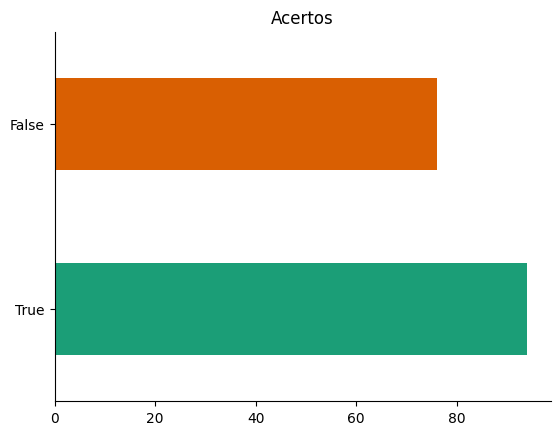

In [ ]:
plt.title('Acertos')
df_results['hit'].value_counts().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

In [ ]:
fig = px.line(df_results, x="cid", y="hit", title='Hit over samples')
fig.show()

In [ ]:
fig = px.line(df_results, x="cid", y="hit@10", title='Hit@10 over samples - Mistral')
fig.show()